# Evaluation of ion suppression correction

In this notebook, I explore different measures to quantify the effect of correcting SpaceM ion intensity data for partial pixel-cell overlap.
 

In [44]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
from src.functions import *
from sklearn.cluster import KMeans
from importlib import reload
import src.functions
# import outer_spacem as osm

In [45]:
condition_name = 'celltype'

The conditions data for the co-culture datasets is established using fluorescence microscopy. The following code is adapted from Martijn and just shows the classification of fluorescence values to celltypes

In [46]:
adata = sc.read('data/Mx_Co_Cultured/pipeline_files/batch_sm_matrix.h5ad')
adata_cor = sc.read('data/Mx_Co_Cultured/pipeline_files/corrected_batch_sm_matrix.h5ad')

HeLa      715
NIH3T3    492
Name: celltype, dtype: int64


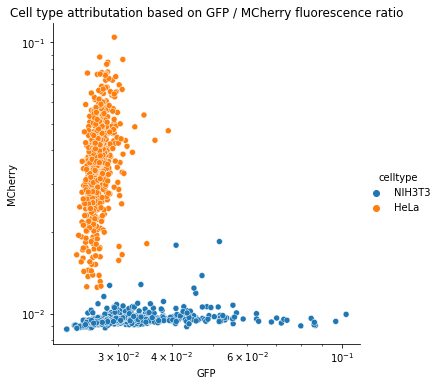

In [47]:
condition_metadata = pd.read_csv('data/Mx_Co_Cultured/MORPHnMOL.csv')
condition_metadata.index = [CELL_PRE + str(i) for i in condition_metadata.ObjectNumber]
condition_metadata['GFP'] = condition_metadata.Intensity_MeanIntensity_GFP_quantif
condition_metadata['MCherry'] = condition_metadata.Intensity_MeanIntensity_mCherry_quantif
condition_metadata['fluorescence_ratio'] = np.log(condition_metadata.GFP / condition_metadata.MCherry)

#condition_metadata['celltype'] = 'HeLa' if condition_metadata.fluorescence_ratio < 0.8 else 'NIH3T3'
condition_metadata['celltype'] = np.where(condition_metadata.fluorescence_ratio < 0.8, 'HeLa', 'NIH3T3')

print(condition_metadata['celltype'].value_counts())

plot = sns.relplot(data=condition_metadata, x='GFP', y='MCherry', hue='celltype')
plot.set(xscale='log')
plot.set(yscale='log')
plot.set(title='Cell type attributation based on GFP / MCherry fluorescence ratio')

The co-culture dataset was originally used in the original SpaceM manuscript. The corresponding metadata file `MORPHnMOL.csv` subsets the list of annotated molecules from 104 to 58. Consequently, only these molecules will be explored in the following. Analogously, only the cells present in both the uncorrected and corrected spatiomolecular matrices are kept for the analysis.

In [48]:
included_cells = adata.obs.index.intersection(condition_metadata.index)
all_molecules = adata.var.index
included_molecules = adata.var.index.intersection(condition_metadata.columns)

adata = adata[included_cells, all_molecules]
adata_cor = adata_cor[included_cells, all_molecules]

print(adata.shape)
print(adata_cor.shape)

(1207, 58)
(1207, 58)


In the following, both spatiomolecular matrices are filtered and scaled to zero-mean and unit variance.

In [49]:
def preprocess(adata):
    sc.pp.filter_cells(adata, min_genes=5)
    sc.pp.filter_genes(adata, min_cells=1)
    adata.raw = adata
    # sc.pp.normalize_total(adata, target_sum=None)
    # sc.pp.log1p(adata)
    sc.pp.scale(adata)

preprocess(adata)
preprocess(adata_cor)


print(adata.shape)
print(adata_cor.shape)


/opt/conda/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


(1137, 58)
(1137, 58)


In [50]:
adata.obs['correction'] = 'uncorrected'
adata_cor.obs['correction'] = 'ISM correction'

In [51]:
conc_adata = ad.concat({'uncorrected': adata, 'ISM correction': adata_cor}, label='correction', index_unique='_', merge='same')

In [52]:
sc.tl.rank_genes_groups(adata=conc_adata, groupby='correction', use_raw=True, method='t-test_overestim_var', n_genes=20)
# sc.pl.rank_genes_groups_tracksplot(conc_adata, groupby='correction')
# sc.pl.rank_genes_groups_violin(conc_adata, groups=['0', '1'])
# .to_csv('data/Mx_Co_Cultured/metabolite-set.csv')

/opt/conda/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/opt/conda/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [53]:
top_uncor = sc.get.rank_genes_groups_df(conc_adata, group='uncorrected')
top_cor = sc.get.rank_genes_groups_df(conc_adata, group='ISM correction')
tops_dea = pd.concat({'strongly_corr': top_uncor, 'hardly_corr': top_cor})
tops_dea

names     scores  logfoldchanges          pvals  \
strongly_corr 0      C20H32O2  52.646675             inf  5.216029e-314   
              1    C41H80NO8P  47.411564      753.036682  6.143312e-279   
              2      C18H34O2  45.986629             inf  4.795384e-282   
              3    C43H78NO8P  45.899193      837.673096  8.397237e-265   
              4     C21H39O6P  45.631268             inf  4.974824e-277   
              5     C39H73O8P  44.913712      768.407043  1.933396e-259   
              6    C39H76NO8P  41.309975      461.633484  6.540145e-234   
              7      C16H30O2  39.891312      299.404755  8.400096e-232   
              8     C35H67O8P  39.787674      350.526001  2.294697e-228   
              9    C23H48NO7P  37.936390      439.491394  2.631245e-221   
              10   C25H44NO7P  33.750267      343.093964  4.965141e-182   
              11    C37H71O8P  33.154114             inf  2.991046e-183   
              12     C18H36O2  32.715153             NaN  7.871740e-180   
              13    C9H19O11P  32.074871      284.232910  1.530171e-168   
              14    C21H41O7P  31.836212      343.808655  1.457687e-173   
              15   C37H74NO8P  28.001574      214.182022  2.906053e-136   
              16    C19H37O6P  26.198051             NaN  5.384331e-126   
              17   C27H53O12P  25.279472             inf  4.442265e-120   
              18     C6H13O9P  25.016823             NaN  2.730181e-119   
              19    C19H39O7P  24.580065      251.068085  1.670088e-113   
hardly_corr   0   C40H76NO10P  -2.382928      -10.361712   1.726011e-02   
              1   C44H78NO10P  -2.465764      -10.568179   1.374919e-02   
              2    C44H84NO6P  -2.641705      -11.027918   8.307803e-03   
              3    C45H82NO8P  -2.709893      -11.323949   6.782439e-03   
              4    C43H78NO7P  -2.773828      -13.031256   5.586707e-03   
              5    C41H74NO8P  -2.813891      -13.973278   4.938044e-03   
              6    C45H78NO8P  -2.932301      -18.941956   3.399163e-03   
              7    C43H76NO7P  -2.938869      -18.743433   3.328207e-03   
              8    C43H79O13P  -2.984794      -23.205973   2.868801e-03   
              9    C41H74NO7P  -3.086175      -19.309210   2.052491e-03   
              10    C43H75O8P  -3.384500      -19.004618   7.255605e-04   
              11   C29H49O12P  -3.599070      -19.851044   3.263993e-04   
              12    C43H73O8P  -3.681015      -20.749765   2.379663e-04   
              13   C45H80NO8P  -3.849231      -26.149202   1.218448e-04   
              14   C43H82NO8P  -4.218044      -27.301565   2.563914e-05   
              15  C42H80NO10P  -4.224694      -42.708408   2.489913e-05   
              16    C41H75O8P  -4.226166      -30.066055   2.473770e-05   
              17   C25H50NO7P  -4.481243      -23.457966   7.802402e-06   
              18   C43H81O13P  -4.764417     -138.497528   2.017223e-06   
              19   C42H82NO6P  -4.827662      -36.010441   1.480165e-06   

                      pvals_adj  
strongly_corr 0   3.025297e-312  
              1   1.187707e-277  
              2   1.390661e-280  
              3   9.740795e-264  
              4   7.213494e-276  
              5   1.868950e-258  
              6   5.418977e-233  
              7   6.090070e-231  
              8   1.478805e-227  
              9   1.526122e-220  
              10  2.399818e-181  
              11  1.577097e-182  
              12  3.512007e-179  
              13  5.916662e-168  
              14  6.038989e-173  
              15  1.053444e-135  
              16  1.837007e-125  
              17  1.431397e-119  
              18  8.334236e-119  
              19  4.843254e-113  
hardly_corr   0    1.726011e-02  
              1    1.399041e-02  
              2    8.604510e-03  
              3    7.152390e-03  
              4    6.000538e-03  
              5    5.403898e-03  
              6    3.791374e-0

In [54]:
tops_slope = pd.concat({'strongly_corr': adata_cor.var.sort_values(by='correction_quantreg_slope').tail(20), 
                                   'hardly_corr': adata_cor.var.sort_values(by='correction_quantreg_slope').head(20)})

tops_slope

correction_full_pixel_avg_intensities  \
strongly_corr C19H37O6P                              1381.563110   
              C21H41O6P                              1330.686646   
              C37H74NO8P                               94.128250   
              C27H53O12P                              564.646790   
              C23H48NO7P                              290.385406   
              C6H13O9P                               1146.634399   
              C21H41O7P                               267.520782   
              C37H71O8P                               531.036743   
              C6H11O8P                               2377.343018   
              C16H30O2                                121.372726   
              C35H67O8P                               111.688469   
              C25H44NO7P                              120.748428   
              C9H19O11P                               104.372345   
              C18H34O2                                352.049988   
              C39H76NO8P                               81.244026   
              C21H39O6P                               364.706390   
              C41H80NO8P                              123.135040   
              C39H73O8P                               109.674606   
              C43H78NO8P                               98.611099   
              C20H32O2                                124.950768   
hardly_corr   C35H69O8P                               350.298309   
              C34H68NO6P                              262.634186   
              C37H69O8P                                 0.000000   
              C43H81O13P                                0.000000   
              C38H73O8P                                 0.000000   
              C39H71O8P                                 0.000000   
              C39H75O8P                                 0.000000   
              C45H78NO8P                                0.000000   
              C40H76NO10P                               0.000000   
              C41H71O8P                                 0.000000   
              C43H82NO8P                                0.000000   
              C41H74NO7P                                0.000000   
              C41H74NO8P                                0.000000   
              C41H75O8P                                 0.000000   
              C41H78NO8P                                0.000000   
              C44H84NO6P                                0.000000   
              C42H80NO10P                               0.000000   
              C42H82NO6P                                0.000000   
              C43H73O8P                                 0.000000   
              C43H75O8P                                 0.000000   

                           correction_n_datapoints  correction_using_ion_pool  \
strongly_corr C19H37O6P                       1199                      False   
              C21H41O6P                       1199                      False   
              C37H74NO8P                      1002                      False   
              C27H53O12P                      1197                      False   
              C23H48NO7P                      1186                      False   
              C6H13O9P                        1198                      False   
              C21H41O7P                       1166                      False   
              C37H71O8P                       1194                      False   
              C6H11O8P                        1199                      False   
              C16H30O2                        1144                      False   
              C35H67O8P                       1048                      False   
              C25H44NO7P                       996                      False   
              C9H19O11P                        930                      False   
              C18H34O2                        1163                      False   
              C39H76NO8

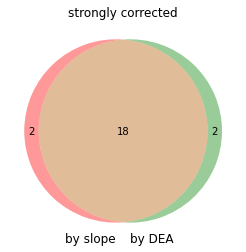

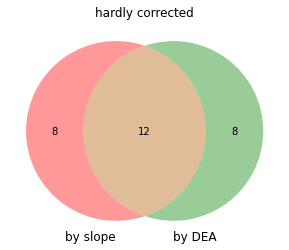

In [55]:
from matplotlib_venn import venn2

venn2([set(tops_slope.loc['strongly_corr'].index),
       set(tops_dea.loc['strongly_corr'].names)],
       set_labels = ['by slope', 'by DEA']
)
plt.title('strongly corrected')
plt.show()
venn2([set(tops_slope.loc['hardly_corr'].index),
       set(tops_dea.loc['hardly_corr'].names)],
       set_labels = ['by slope', 'by DEA']
)
plt.title('hardly corrected')
plt.show()

In [56]:
conc_adata_raw = conc_adata.copy()
conc_adata_raw.X = conc_adata_raw.raw.X
ions = list(top_uncor['names']) + list(top_cor['names'])
changed_ions_df = sc.get.obs_df(conc_adata_raw, keys=(['correction', 'celltype', 'ObjectNumber']+ions))
plot_df = changed_ions_df.melt(id_vars=['correction', 'celltype', 'ObjectNumber'], var_name='ion').pivot(index=['ion', 'celltype', 'ObjectNumber'], columns='correction', values='value')
plot_df.reset_index(level=[0, 1], inplace=True)
plot_df['group'] = ['hardly corr' if (ion in list(top_cor['names'])) else 'strongly corr' for ion in plot_df['ion'] ]

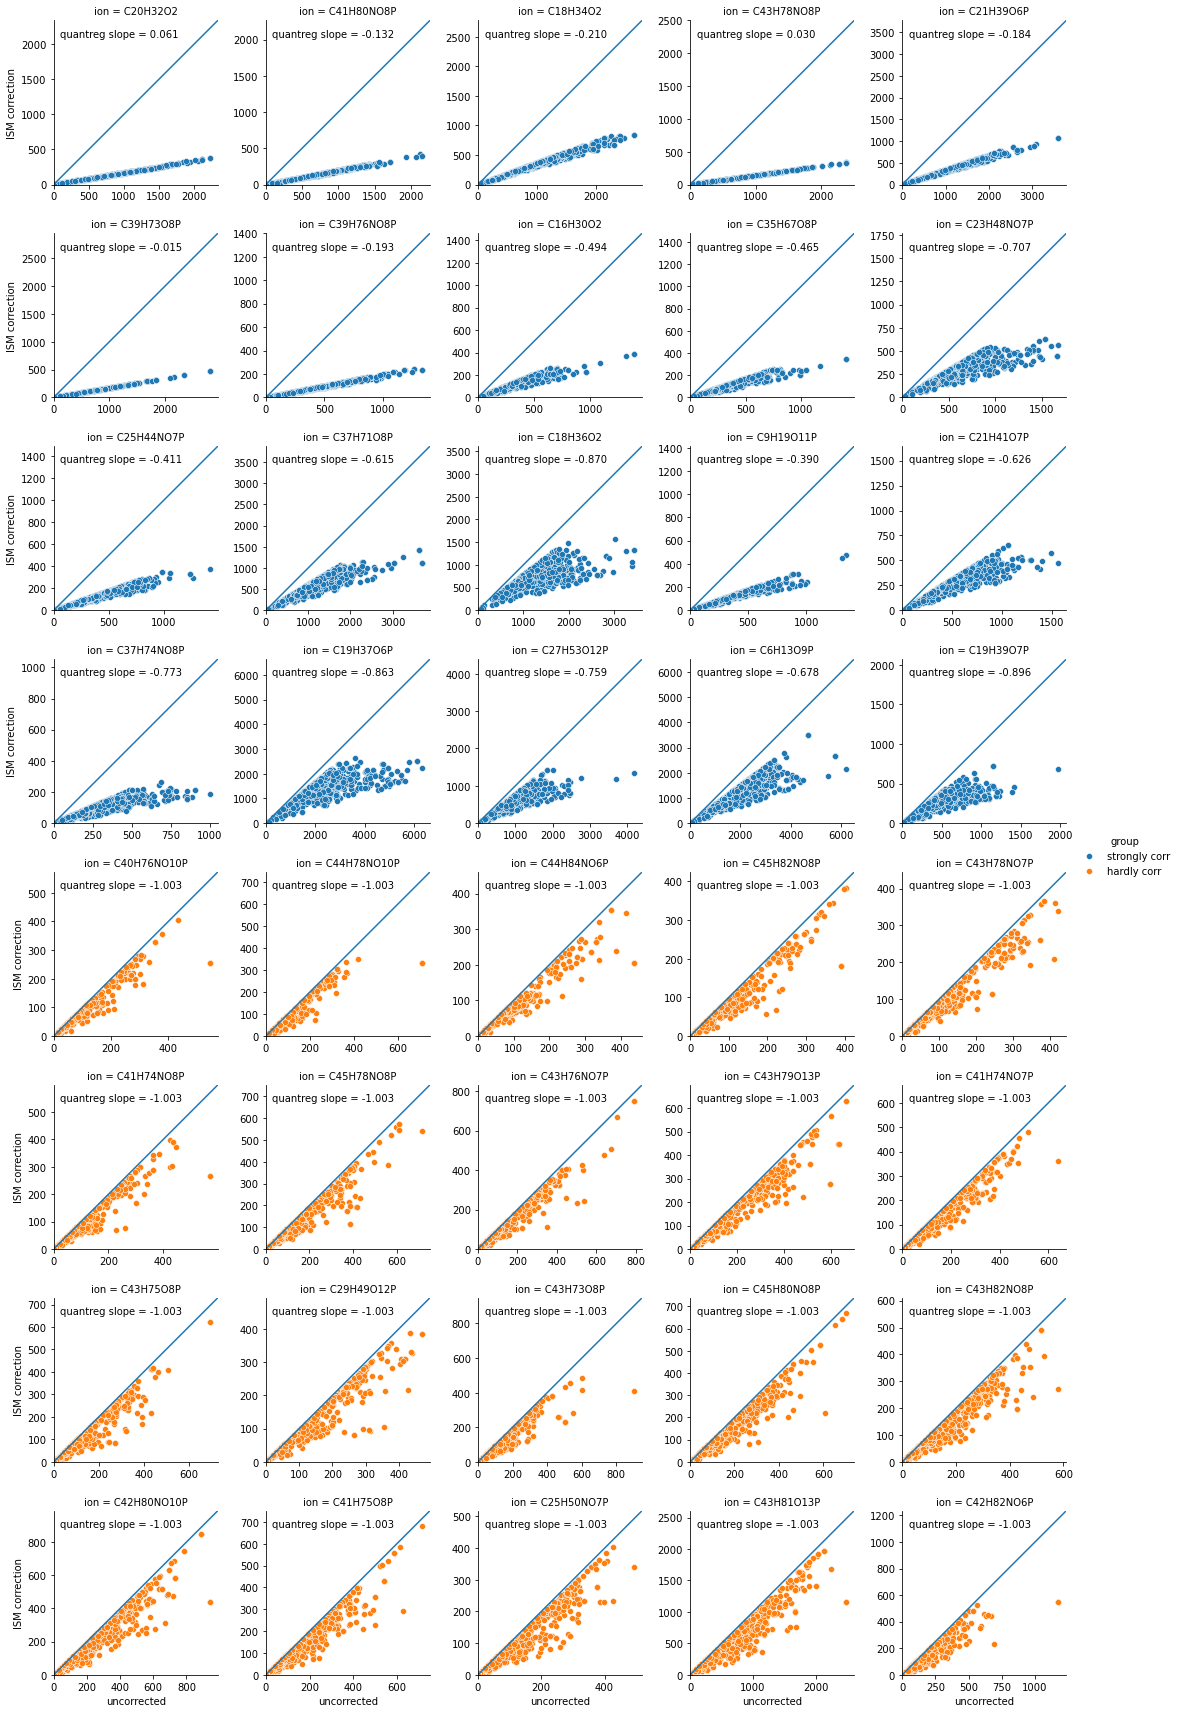

In [57]:
slopes = [adata_cor.var.loc[ion, 'correction_quantreg_slope'] for ion in ions]
grid = sns.FacetGrid(plot_df, col='ion', hue='group', col_wrap=5, sharex=False, sharey=False, col_order=ions)
grid.map(sns.scatterplot, 'uncorrected', 'ISM correction').add_legend()
grid.set(aspect = 1)
for i, ax in enumerate(grid.axes.flat): 
    lim = max([ax.get_xlim()[1], ax.get_ylim()[1]])
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.axline((0,0), slope=1)
    ax.text(0.04*lim, 0.9*lim, 'quantreg slope = %1.3f'%slopes[i])
   

In [58]:
ea_ad = conc_adata[:, tops_slope.loc['strongly_corr'].index].copy().transpose()

df = ea_ad.to_df()
cond = list(ea_ad.var['correction'])
annot = list(ea_ad.obs_names)

data = [df, annot, cond]

In [59]:
import rpy2

In [60]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [61]:
%%R -i data

library(bmetenrichr)


test <-
  initEnrichment(scmatrix = data[[1]],
                 annotations = as.character(data[[2]]),
                 conditions = as.character(data[[3]]),
                 condition.x = "uncorrected",
                 condition.y = "ISM correction"
                )
    
test <- rankScore(test, ranking.by = 't.test')
test <- calcEnrichment(test, n = 100)


Parsing isomers...
single-cell metabolomics matrix of 20 metabolites and 2274 cells
active pathway: LION 

conditions: uncorrected, ISM correction 

condition.x: uncorrected 
condition.y: ISM correction 

Bootstrapping...
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |+                                                 | 2 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |+++                                               | 6 % ~00s           |++++                                              | 7 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10

R[write to console]: 85.0% of annotations were matched to pathway




Perform enrichment analysis...
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04s           |+                                                 | 2 % ~04s           |++                                                | 3 % ~04s           |++                                                | 4 % ~04s           |+++                                               | 5 % ~04s           |+++                                               | 6 % ~04s           |++++                                              | 7 % ~04s           |++++                                              | 8 % ~04s           |+++++                                             | 9 % ~04s           |+++++                                             | 10% ~04s           |++++++                                            | 11% ~04s           |++++++                                            | 12% ~04s           |+++++++                      

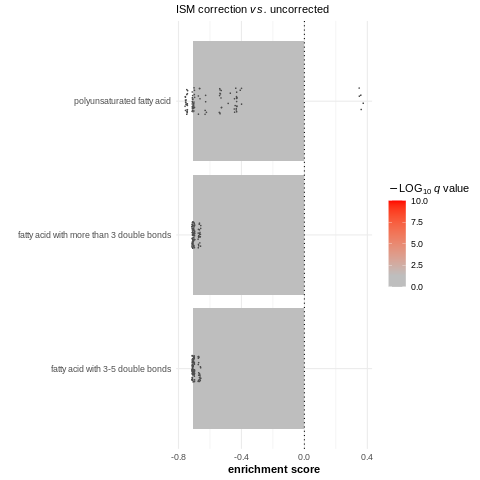

In [62]:
%%R

plotEnrichment(test, min.annotations = 1, q.value.cutoff = .2, by.statistic = "ES")

In the following graphs, the uncorrected data is shown before the corrected data. Initially, the data is visualized using PCA and UMAP

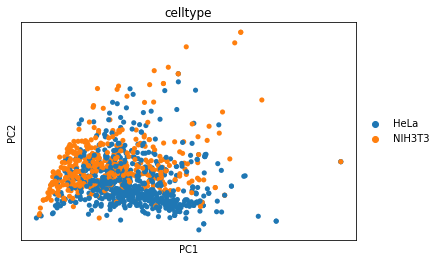

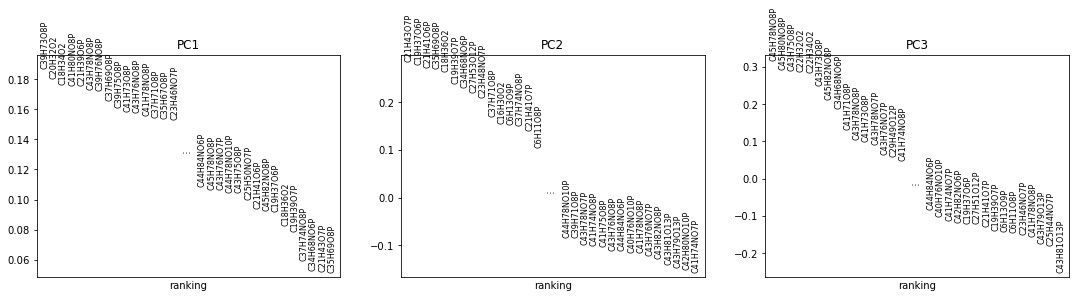

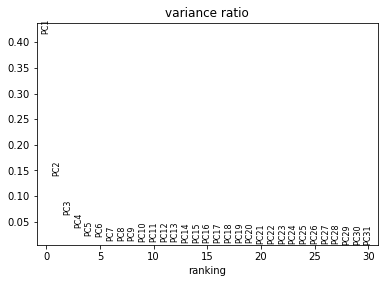

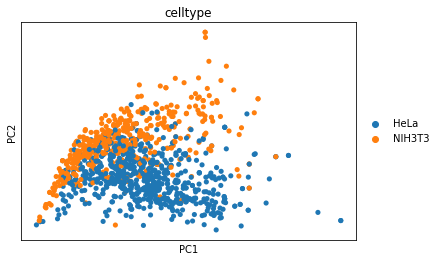

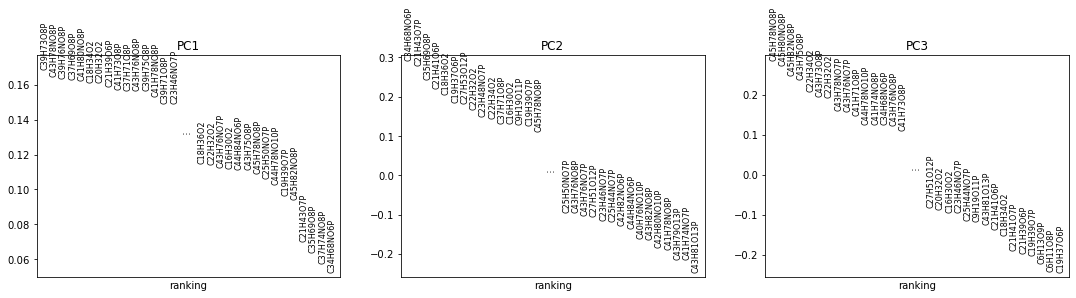

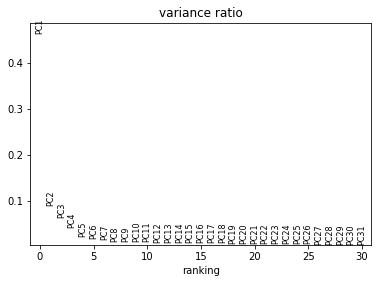

In [63]:
def dimred_pca(adata):
    sc.pp.pca(adata)
    sc.pl.pca_overview(adata, color='celltype')

dimred_pca(adata)
dimred_pca(adata_cor)

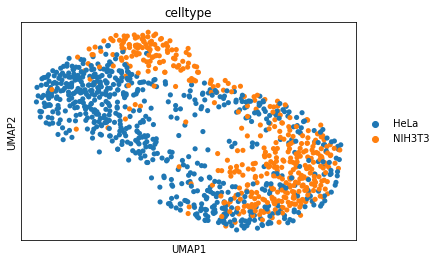

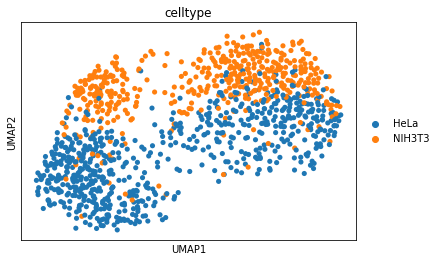

In [64]:
def dimred_umap(adata, min_dist = 0.5):
    sc.pp.neighbors(adata, n_neighbors=200, metric='cosine')
    sc.tl.umap(adata, min_dist=min_dist, spread=2.0, random_state=1, n_components=2)
    sc.pl.umap(adata, color=condition_name)
    # f = osm.pl.highlight_scatterplot(
    #     data = adata,
    #     obsm_key = "X_umap",
    #     hue = condition_name,
    #     col = condition_name,
    #     palette = "cividis",
    #     height = 5,
    #     scatter_kwargs = dict(s=10)
    # )

    # f.add_legend(markerscale=3)

    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

dimred_umap(adata)
dimred_umap(adata_cor)


There exist several methods for unsupervised clustering, that can be applied to dimensionality-reduced data. Here, I show kMeans clustering, Leiden clustering and a variant of the latter (adapted from the SpaceM manuscript: curated leiden). Both kMeans and Leiden clustering appear to fail at distinguishing the two celltypes as they split the data along the short axis of the UMAP visualization. However, the celltypes are separated along the long axis. The curated Leiden algorithm from Rappez et al. finds smaller Leiden clusters and assigns them to either celltype depending on the nature of the majority of cells. This method of finer granularity does better reproduce the separation between the two celltypes.

In [ ]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import accuracy_score, silhouette_score

def clustering_methods(adata):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(adata.X)
    adata.obs['kmeans'] = kmeans.labels_.astype(str)

    sc.tl.leiden(adata, resolution=0.3)
    sc.tl.leiden(adata, resolution=2, key_added='leiden_fine')

    leiden = np.array(adata.obs['leiden_fine'].values)
    leiden_curated = np.copy(leiden)
    fc = np.array(adata.obs['celltype'].values)
    for cluster in np.unique(leiden):
        labels, counts = np.unique(fc[leiden == cluster], return_counts=True)
        leiden_curated[leiden == cluster] = str(labels[counts == np.max(counts)][0])
    adata.obs['leiden_curated'] = leiden_curated

    sc.pl.umap(adata, color=['kmeans', 'leiden', 'leiden_curated', 'celltype'])
    print('Leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs['celltype'].replace(['HeLa', 'NIH3T3'], ['0', '1']), y_pred = adata.obs['leiden']))
    print('Curated leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs['celltype'], y_pred = adata.obs['leiden_curated']))
    print('KMeans completeness score: %1.4f' % completeness_score(adata.obs['celltype'], adata.obs['kmeans']))
    print('KMeans silhouette coefficient: %1.4f' % silhouette_score(adata.X, adata.obs['kmeans']))

clustering_methods(adata)
clustering_methods(adata_cor)


Linear discriminant analysis is a linear classifier that can be trained and applied to the ion intensity data in order to further examine the separation of the different conditions (celltypes). In general, the performance of the classifier depends on the underlying data, the trained model and how they work with each other. Assuming the model itself has equal performance in both cases, higher the accuracy of the classifier can be attributed to a better separation of the data.

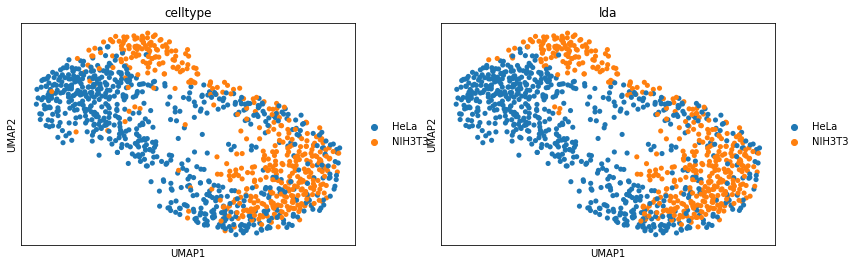

Classification accuracy after 10-fold cross-validation: 0.9174 (±0.0241)


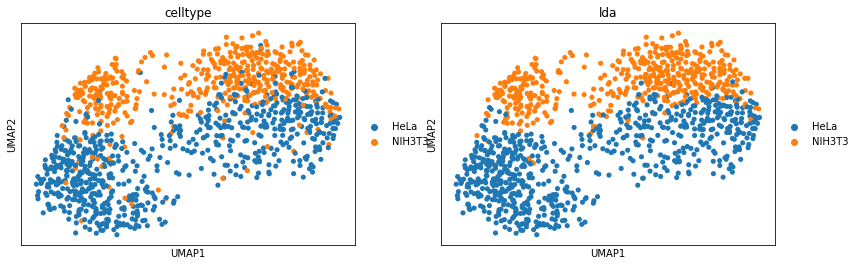

Classification accuracy after 10-fold cross-validation: 0.9113 (±0.0245)


In [66]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def test_classifier(adata, model, predictors, result, name):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, predictors, result, scoring='accuracy', cv=cv, n_jobs=multiprocessing.cpu_count())
    
    adata.obs[name] = model.predict(adata.X)
    sc.pl.umap(adata, color=['celltype', 'lda'])
    print("Classification accuracy after 10-fold cross-validation: %1.4f (±%1.4f)" % (np.mean(scores), np.std(scores)))  

def LDA(adata):
    predictors = adata.X
    result = adata.obs['celltype']
    model = LinearDiscriminantAnalysis()
    model.fit(predictors, result)  

    test_classifier(adata, model, predictors, result, name = 'lda')

LDA(adata) 
LDA(adata_cor) 

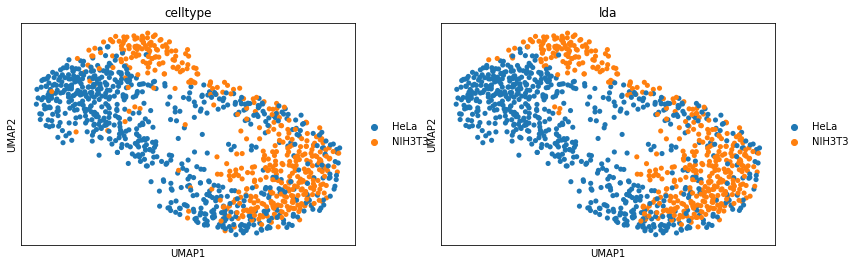

Classification accuracy after 10-fold cross-validation: 0.9062 (±0.0244)


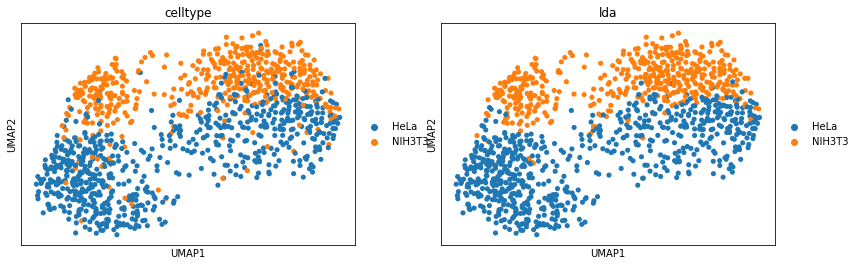

Classification accuracy after 10-fold cross-validation: 0.9095 (±0.0213)


In [67]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(adata, max_depth = 10):
    predictors = adata.X
    result = adata.obs['celltype']
    model = RandomForestClassifier(random_state=1, max_depth=max_depth)
    model.fit(predictors, result)  

    test_classifier(adata, model, predictors, result, name = 'random_forest') 


random_forest(adata) 
random_forest(adata_cor) 

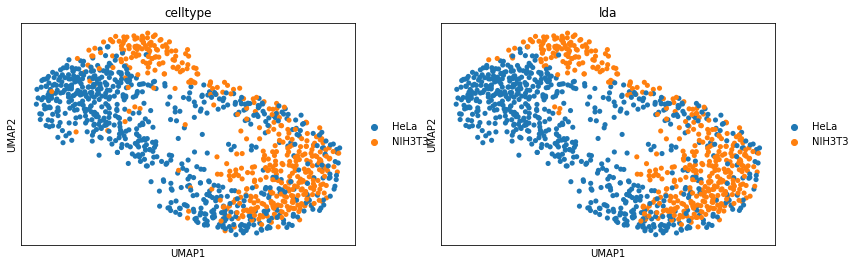

Classification accuracy after 10-fold cross-validation: 0.8965 (±0.0280)


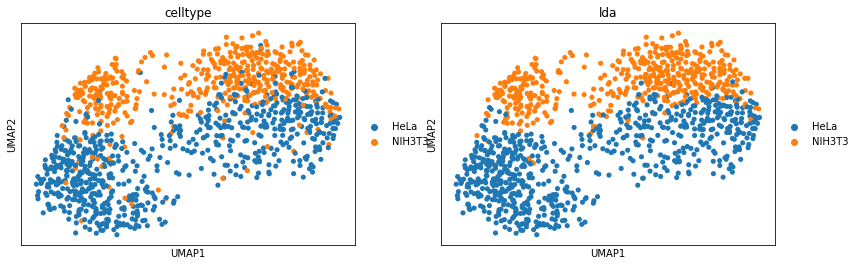

Classification accuracy after 10-fold cross-validation: 0.9062 (±0.0267)


In [70]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline

def knn_classifier(adata, n_neighbors = 20):
    predictors = adata.X
    result = adata.obs['celltype']
    nca = NeighborhoodComponentsAnalysis(random_state=1)
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    model = Pipeline([('nca', nca), ('knn', knn)])
    knn.fit(predictors, result)  

    test_classifier(adata, knn, predictors, result, name = 'knn')


knn_classifier(adata) 
knn_classifier(adata_cor) 

Finally, Martijn developed an intermixing metric for the separation of different conditions based on the local neighborhood (euclidian distance) of every data point in dimensionality-reduced space. I have extended this single-valued measure to a curve on neighborhood-scale and introduced a correction factor for unbalanced datasets. For the co-culture dataset, this metric shows a clear difference in the group intermixing of uncorrected and corrected ion intensities. Intermixing is almost 50% lower after correction across neighborhood sizes.

227it [00:07, 30.91it/s]
227it [00:01, 218.16it/s]
227it [00:00, 228.70it/s]
227it [00:00, 235.09it/s]
227it [00:01, 216.31it/s]
227it [00:01, 224.50it/s]


,,mean,sd,rel_neighborhood
X_uncorrected,10,0.204834,0.263783,0.091837
X_ISM correction,10,0.196342,0.264352,0.091837
X_pca_uncorrected,10,0.200389,0.266097,0.091837
X_pca_ISM correction,10,0.197660,0.259012,0.091837
X_umap_uncorrected,10,0.252952,0.303623,0.091837
X_umap_ISM correction,10,0.176058,0.287960,0.091837


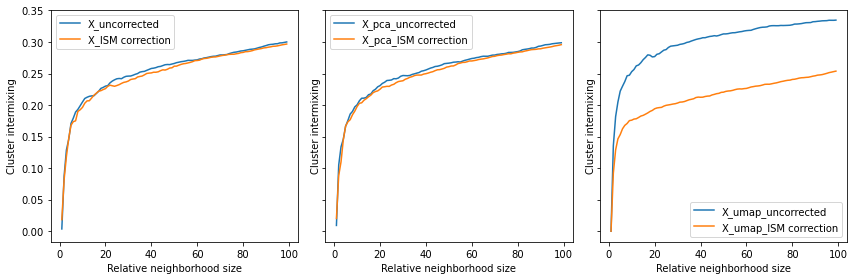

In [71]:
reload(src.functions)
from src.functions import intermixing
intermixing({'uncorrected': adata, 'ISM correction': adata_cor}, condition_name=condition_name, sample_frac=0.2)

For a better comparison to Martijns results, I also calculate the intermixing metric for the fixed neighborhood of $n=10$, with and without normalization to group imbalance. Martijn reports intermixing values of $0.152$ for ISM correction and $0.215$ for uncorrected data.

In [72]:
pd.concat([intermixing_metric_sampled(adata, condition_name, neighborhood_size=[10], n_datapoints=1, label='none', normalized=True),
intermixing_metric_sampled(adata_cor, condition_name, neighborhood_size=[10], n_datapoints=1, label='ISM', normalized=True),
intermixing_metric_sampled(adata, condition_name, neighborhood_size=[10], n_datapoints=1, label='none', normalized=False),
intermixing_metric_sampled(adata_cor, condition_name, neighborhood_size=[10], n_datapoints=1, label='ISM', normalized=False)], axis=0, keys=['none', 'ISM', 'none_raw', 'ISM_raw'])

227it [00:00, 418.64it/s]
227it [00:00, 494.38it/s]
227it [00:00, 470.45it/s]
227it [00:00, 533.06it/s]


,,mean,sd,rel_neighborhood
none,10,0.252952,0.303623,0.0
ISM,10,0.176058,0.287960,0.0
none_raw,10,0.242291,0.273894,0.0
ISM_raw,10,0.166960,0.238934,0.0


As visible in UMAP space, the two celltypes are separated along the long axis of the cluster instead of the short axis. This may indicate that the metabolic profiles within two populations themselves are more heterogenic than between them. Thus an additional biological or technical factor seems to influence the metabolic profiles. To investigate this furter, I did a differential expression analysis between the two leiden clusters. On top of that, it would be useful to complement this with an enrichment analysis.


In [ ]:
sc.tl.rank_genes_groups(adata=adata, groupby='leiden', use_raw=True, method='t-test_overestim_var', n_genes=25)
# sc.pl.rank_genes_groups_tracksplot(adata, groupby='leiden')
sc.pl.rank_genes_groups_violin(adata, groups=['0', '1'])
sc.get.rank_genes_groups_df(adata, group='0')['names'].to_csv('data/Mx_Co_Cultured/metabolite-set.csv')